## Xray set

In [1]:
import importlib
from xray import xray
import imageio.v2 as imageio
import cv2   
import cupy as cp
import numpy as np

importlib.reload(xray)

xrayset = xray.xrayset(
        name="__phantom",
        sheets=450,
        voltage=120,
        height=1024,
        output_height=500
    )

  0%|          | 0/450 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
print(xrayset.mean, xrayset.std)

202.13799876610375 28.001571358626776


170.14660365821723


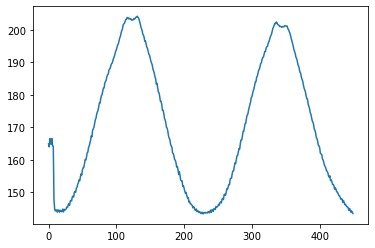

In [3]:
import matplotlib.pyplot as plt

stat = [cp.asnumpy(s) for s in xrayset.stat]
plt.plot(stat)
print(np.average(stat))

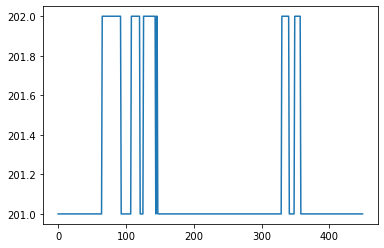

In [8]:
avg = [int(cp.average(img[img > 60])) for img in xrayset.img]
plt.plot(avg)

In [10]:
imgs = []
for img in xrayset.img:
    imgs.append(cp.asnumpy(img))
imageio.mimsave("x.gif", imgs)

In [34]:
import fbp.tompy as fbp
import cupy as cp

# fbp from xrayset
rec2 = fbp.fbpset(
        xrayset,
        height=1000,
        # adjust_alpha=4.,
        # adjust_beta=-120.,
        angle=50,
        sidepad=200,
        rotate=195,
        load_all=False
    )

# print(cp.asnumpy(rec2.get(5)))
# imageio.imsave("test.png", cp.asnumpy(rec2.get(5)))
# imageio.imsave("x.png", cp.asnumpy(rec2.x.img[200]).ravel())

In [45]:
# import matplotlib.pyplot as plt

# img = cp.asnumpy(rec2.get(350)).astype("float64")

# imgs = [cp.asnumpy(rec2.get(i)).astype("uint8") for i in range (200, 500, 5)]

# imageio.mimsave("test1.gif", imgs)

In [1]:
import fbp.tompy as fbp
import cupy as cp
import importlib
from xray import xray
import imageio.v2 as imageio
import cv2   
import cupy as cp
import numpy as np
import os, sys
from tqdm.notebook import tqdm

importlib.reload(xray)

volname = "__phantom"

# load xrays
xrayset = xray.xrayset(
        name=volname,
        sheets=450,
        voltage=120,
        height=1024,
        output_height=500
    )

# fbp from xrayset
rec = fbp.fbpset(
        xrayset,
        height=1000,
        # adjust_alpha=4.,
        # adjust_beta=-120.,
        angle=50,
        sidepad=200,
        rotate=195,
        load_all=False
    )


  0%|          | 0/450 [00:00<?, ?it/s]

500 500


  0%|          | 0/61 [00:00<?, ?it/s]

In [6]:
def adjust(img, alpha, beta):
    """Adjust contrast and brightness

    Alpha: contrast, Beta: brightness

    Args:
        img (numpy array): input image

    Returns:
        numpy array: output image
    """
    dst = alpha * img + beta
    return cp.clip(dst, 0, 255).astype(cp.uint8)


cropheight = 600
cropwidth = 600
cropstarty = int((1000 - cropheight) / 2)
cropstartx = int((1000 - cropwidth) / 2)

# which fbp to use
use_range = [200, 500]
spacing = 5

imgs = [rec.get(i).astype("uint8") for i in tqdm(range(use_range[0], use_range[1], spacing))]

# imgs = [rec.get(450).astype("uint8")]

img_fold_AB = "./pix2pix/datasets/ctfbp/test"

for idx, img in enumerate(tqdm(imgs)):
    cropped = img[cropstarty:cropstarty + cropheight, cropstartx:cropstartx + cropwidth]
    cropped = cp.array(cv2.resize(cp.asnumpy(cropped), (512, 512)))
    cropped = adjust(cropped, 1.0, 100)
    black = cp.full(cp.shape(cropped), 0)
    im_AB = cp.asnumpy(cp.concatenate([black, cropped], 1)).astype("uint8")
    # imageio.imsave("test.png", im_AB)
    path_AB = os.path.join(img_fold_AB, f"{volname}_{idx:02d}.jpg")
    if not cv2.imwrite("./" + path_AB, im_AB):
        print("NO!")
        sys.exit(0)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [3]:
%slack